In [3]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchsummary import summary

# Utilities
from IPython.display import display
from tqdm.notebook import tqdm

# Custom modules
from preprocessing_utils import get_class_names, get_policies, get_datasets, get_transform
from training_utils import predict_model, load_model, plot_roc_curve
from dataset import CheXpertDataset

# LIME (Local Interpretable Model-agnostic Explanations)
import lime
import lime.lime_tabular
import lime.lime_image

In [4]:
transform = get_transform()

# Define the class names for the medical conditions
class_names = get_class_names()

# Define the policies for dataset preparation
policies = get_policies()

# Path to the zip file
zip_path = "./chexpert.zip"

# Path to the directory where the datasets will be extracted
data_dir = "./CheXpert-v1.0-small"

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the batch size
batch_size = 16

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

In [5]:
# Load the datasets
train_df, validation_df, test_df = get_datasets(zip_path)

if train_df is None or validation_df is None or test_df is None:
    print("Error loading the datasets.")
else:
    print("Datasets loaded successfully.")

Datasets loaded successfully.


In [ ]:
test_df

,path,Pleural Effusion
0,CheXpert-v1.0-small/valid/patient64735/study1/...,0
1,CheXpert-v1.0-small/valid/patient64634/study1/...,0
2,CheXpert-v1.0-small/valid/patient64712/study1/...,0
3,CheXpert-v1.0-small/valid/patient64662/study1/...,0
4,CheXpert-v1.0-small/valid/patient64578/study1/...,0
...,...,...
197,CheXpert-v1.0-small/valid/patient64672/study1/...,0
198,CheXpert-v1.0-small/valid/patient64676/study1/...,1
199,CheXpert-v1.0-small/valid/patient64611/study1/...,0
200,CheXpert-v1.0-small/valid/patient64679/study1/...,0


In [ ]:
import zipfile
import os

# Check if the dataset is already extracted, if not extract it
if not os.path.exists(data_dir):
    print("Extracting the dataset...")
    #unzip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    #list files in the extracted dir
    os.listdir(data_dir)
else:
    print("Dataset already extracted.")

### Extraction of ground truth samples (4 images)

In [2]:
path = r"ground_truth_data\bbox320x320.xlsx"
ground_truth_df = pd.read_excel(path)
ground_truth_df.head()

,Image,x_start,y_start,x_end,y_end,x_start.1,y_start .1,x_end .1,y_end.1
0,Test,48,160,144,288,NaN,NaN,NaN,NaN
1,Rad_1,176,128,288,256,NaN,NaN,NaN,NaN
2,Rad_2,32,128,144,256,NaN,NaN,NaN,NaN
3,Rad_3,32,144,144,288,176.0,144.0,288.0,272.0
4,Rad_5,32,160,144,240,NaN,NaN,NaN,NaN


In [6]:
from PIL import Image
import numpy as np

# Open an image file
image = Image.open("ground_truth_images/Rad_1.png")
image_array = np.array(image)
image_array.shape

(320, 320)

In [7]:
ground_truth_df = ground_truth_df[ground_truth_df['Image '] != 'Test ']

In [8]:
ground_truth_df

,Image,x_start,y_start,x_end,y_end,x_start.1,y_start .1,x_end .1,y_end.1
1,Rad_1,176,128,288,256,NaN,NaN,NaN,NaN
2,Rad_2,32,128,144,256,NaN,NaN,NaN,NaN
3,Rad_3,32,144,144,288,176.0,144.0,288.0,272.0
4,Rad_5,32,160,144,240,NaN,NaN,NaN,NaN


In [9]:
images_paths = []
attributes_list = []

for row, column in ground_truth_df.iterrows():
    if column['Image '] != "Test ":
        path = f"ground_truth_images/{column['Image '].strip()}.png"
        images_paths.append(path)
        attributes_list.append(column[['Image ', 'x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1',
       'y_start .1', 'x_end .1', 'y_end.1']])
        
labels = np.array([1, 1, 1, 1])


In [10]:
ground_truth_images_df = pd.DataFrame({"path": images_paths, "label": labels})
ground_truth_images_df.head()

,path,label
0,ground_truth_images/Rad_1.png,1
1,ground_truth_images/Rad_2.png,1
2,ground_truth_images/Rad_3.png,1
3,ground_truth_images/Rad_5.png,1


#### Uploading the model we trained

## Stacked model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load("finetuned_models/stacked_model.pkl", map_location=device)
state_dict = torch.load("finetuned_models/stacked_model.pth", map_location=device)

C:\Users\bar24\AppData\Local\Temp\ipykernel_9056\3414834214.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("finetuned_models/stacked_model.pkl", map_

## densenet169

In [ ]:
# densenet169 = models.densenet169(weights=models.DenseNet169_Weights.IMAGENET1K_V1)
# model = upload_pretrained_densenet169(densenet169, add_layers=True, n_labels=len(class_names), freeze_layers=True)
model = torch.load("finetuned_models/densenet169.pkl", map_location=device)
state_dict = torch.load("finetuned_models/densenet169.pth", map_location=torch.device('cpu'))

#### DataLoader object

In [12]:
test_dataset = CheXpertDataset(test_df, class_names, transform=transform, zip_path=None)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Evaluation of the model

In [21]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


def evaluate_model(model, test_loader: DataLoader, criterion, device='cuda'):
    """
    Evaluate a trained PyTorch model on a test dataset.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function used during training.
    - device: Device to evaluate the model on ('cpu' or 'cuda').

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Overall accuracy on the test dataset.
    - all_predictions: List of predicted values for all samples.
    - all_labels: List of ground-truth labels for all samples.
    """
    # model.to(device)
    # model.eval()  # Set the model to evaluation mode
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert outputs to binary predictions (multi-label classification)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            # Store predictions and labels
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.numel() # Total elements (samples × labels)
            
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Convert pre`dictions and labels to tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy, all_predictions, all_labels

#### Evaluating the model (densenet121)

In [22]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model, test_loader, criterion)

Evaluating:   0%|          | 0/13 [00:00<?, ?batch/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [23]:
#Here we turn test loader into generator so that we could extract images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [24]:
#Since batch=16 we extract 16 labels and corresponding images
print(f"images shape: {images.shape} | labels shape: {labels.shape}")


images shape: torch.Size([16, 3, 224, 224]) | labels shape: torch.Size([16, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

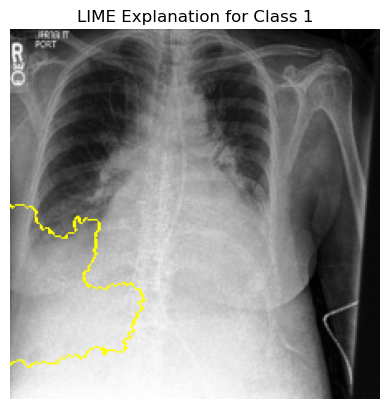

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms
from PIL import Image

# Ensure your model is in evaluation mode and on the proper device.
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def denormalize2numpy(img_tensor):
    # Unnormalize the image: original = normalized * std + mean
    # Since mean=0.5 and std=0.5 for grayscale images:
    unnormalized = img_tensor * 0.5 + 0.5  #torch.Size([3, 224, 224])
    # Convert tensor from (C, H, W) to (H, W, C)
    img_np = unnormalized.permute(1, 2, 0).cpu().numpy() #(224, 224, 3)
    return img_np

# Assuming you have obtained an image from your testloader:
# For example, grabbing the first image from a batch:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[5]  # select the first image from the batch
img_np = denormalize2numpy(img)

# Prediction function for LIME:
def predict_fn(images):
    """
    images: list/array of images in NumPy format (H x W x C), with pixel values in [0, 1].
    Returns: a NumPy array of shape (n_samples, 2) with class probabilities.
    """
    # Convert each LIME image (numpy array) to a PIL image, then to a tensor.
    tensor_images = [
        transforms.ToTensor()(Image.fromarray((img * 255).astype(np.uint8)))
        for img in images
    ]
    # Stack into a single batch tensor of shape (N, C, H, W)
    batch = torch.stack(tensor_images).to(device)
    
    with torch.no_grad():
        outputs = model(batch)  # outputs shape: (batch, 1)
        # Apply sigmoid to get probability for class 1.
        probs_class1 = torch.sigmoid(outputs)
        # Create two-class probabilities: class0 = 1 - p, class1 = p.
        probs = torch.cat([1 - probs_class1, probs_class1], dim=1)
        # print(probs)
    
    return probs.cpu().numpy()

# Create LIME image explainer.
explainer = LimeImageExplainer()

# Explain the prediction for the chosen image.
# For binary classification, we can set top_labels=2.
explanation = explainer.explain_instance(
    img_np,   
    predict_fn,
    top_labels=2,              # With binary classification, there are two labels.
    hide_color=0,
    num_samples=1000           # Number of perturbed samples
)

# Choose the label you wish to explain. For example, to explain class 1 (positive class):
label_to_explain = 1  # or use explanation.top_labels[0] if that suits your needs

# Get the explanation mask.
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=1,
    hide_rest=False
)

# Visualize the explanation.
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Class {label_to_explain}")
plt.axis("off")
plt.show()


# ________________________________________________________________________________________________________________________________________________

### Gradcam based on paper: https://arxiv.org/abs/1610.02391
#### Library: https://github.com/jacobgil/pytorch-grad-cam

In [34]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import ScoreCAM

def apply_gradcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided DenseNet121 model.
    
    Args:
        model: The trained DenseNet121 model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
        target_category: (Optional) Target class index for which to compute Grad-CAM.
    
    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4.
    if target_layer is None:
        try:
            # Using the last convolution from denselayer16 in denseblock4       denseblock4{
            target_layer = [model.features.denseblock4.denselayer16.conv2] #  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                                                                                #} last layer
                                                                            # otherwise this error https://github.com/jacobgil/pytorch-grad-cam/issues/393
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            raise Exception("Not possible to extract the required convolutional layer due to missing attribute.")

    # Create GradCAM object
    cam = GradCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]

    
    print(targets)

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # print(grayscale_cam.min(), grayscale_cam.max())  # Before normalization
    # grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    # print(grayscale_cam.min(), grayscale_cam.max())  # After normalization
        
    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape: #OTHERWISE  <<ValueError: operands could not be broadcast together with shapes (224,224,3) (320,357,3) THIS SH happens >> 
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0])) 
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True) # https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/utils/image.py

    return original_img_resized, overlay


#### GradCAM implementation for ground truth labels

In [29]:
ground_truth_images_df.columns

Index(['path', 'label'], dtype='object')

In [30]:
ground_truth_df.iloc[0]

Image         Rad_1 
x_start          176
y_start          128
x_end            288
y_end            256
x_start.1        NaN
y_start .1       NaN
x_end .1         NaN
y_end.1          NaN
Name: 1, dtype: object

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from StackedModel import StackedModel

def apply_gradcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided model.
    
    Args:
        model: The trained model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
    
    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose a default conv layer based on the model architecture
    if target_layer is None:
        if isinstance(model, models.DenseNet):
            target_layer = [model.features.denseblock4.denselayer16.conv2]
        elif isinstance(model, StackedModel):
            target_layer = [model.base_model1.features.denseblock4.denselayer16.conv2]
        else:
            raise Exception("Target layer not specified and default layer not found for the given model.")

    # Create GradCAM object
    cam = GradCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape:
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0]))
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True)

    return original_img_resized, overlay

In [37]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply Grad-CAM to an example image
image_path = 'path_to_image.jpg'
original_img, overlay = apply_gradcam(model, image_path, transform)

# Display the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(original_img)
plt.title("Resized Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap")
plt.axis("off")

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_image.jpg'

In [35]:
import cv2

for i in range(ground_truth_images_df.shape[0]):
    image_path = ground_truth_images_df.iloc[i]['path']
    actual_label = ground_truth_images_df.iloc[i]["label"]
    
    # Load BBOX coordinates
    x_start, y_start, x_end, y_end, x_start_, y_start_, x_end_, y_end_  = ground_truth_df.iloc[i][['x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1',
       'y_start .1', 'x_end .1', 'y_end.1']]


    print(f"Actual label: {actual_label}")
    
    # Only process images with effusion (label == 1)
    if actual_label == 1:
        original_img, overlay = apply_gradcam(
            model=model, 
            image_path=image_path, 
            transform=transform
        )
        
        # Ensure BBOX coordinates are scaled to 224x224
        original_width, original_height = Image.open(image_path).size
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        
        x_start_rescaled = int(x_start * scale_x)
        y_start_rescaled = int(y_start * scale_y)
        x_end_rescaled = int(x_end * scale_x)
        y_end_rescaled = int(y_end * scale_y)


        # HAndle none values
        # if not pd.notna(x_start_):
        #     print("NOT NONE")
        # else:
        #     print("None")


        

        # Draw BBOX on Original Image
        img_with_bbox = original_img.copy()
        cv2.rectangle(img_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)

        # Draw BBOX on Grad-CAM Overlay
        overlay_with_bbox = overlay.copy()

        cv2.rectangle(overlay_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)
        
        # Display Images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_with_bbox)
        plt.title("Resized Original Image with BBOX")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_with_bbox)
        plt.title("Grad-CAM Heatmap with BBOX")
        plt.axis("off")

        plt.show()


Actual label: 1


Exception: Not possible to extract the required convolutional layer due to missing attribute.

#### Test dataframe

In [33]:
test_df_filtered = test_df[test_df['Pleural Effusion'] == 1]

for i in range(13, 60, 3):
    image_path = test_df_filtered.iloc[i]['path']
    actual_label = test_df_filtered.iloc[i]["Pleural Effusion"]  

    print(f"actual label {actual_label}")
    # Only process images with effusion (label==1)
    if actual_label == 1:
        original_img, overlay = apply_gradcam(
            model=model, 
            image_path=image_path, 
            transform=transform,
        )
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title("Resized Original Image Pleural Effusion")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(overlay)
        plt.title("Grad-CAM Heatmap Pleual Effusion")
        plt.axis("off")
        
        
        plt.show()


actual label 1


ValueError: too many values to unpack (expected 2)

#### ScoreCAM

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import ScoreCAM

def apply_scorecam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided DenseNet121 model.
    
    Args:
        model: The trained DenseNet121 model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
        target_category: (Optional) Target class index for which to compute Grad-CAM.
    
    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4.
    if target_layer is None:
        try:
            # Using the last convolution from denselayer16 in denseblock4       denseblock4{
            target_layer = [model.features.denseblock4.denselayer16.conv2] #  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                                                                                #} last layer11ts111
                                                                            # otherwise this error https://github.com/jacobgil/pytorch-grad-cam/issues/393
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            return "Not possible to extract the required convolutional layer due to missing attribute."

    # Create GradCAM object
    cam = ScoreCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]

    
    # print(targets)

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # print(grayscale_cam.min(), grayscale_cam.max())  # Before normalization
    # grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    # print(grayscale_cam.min(), grayscale_cam.max())  # After normalization
        
    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape: #OTHERWISE  <<ValueError: operands could not be broadcast together with shapes (224,224,3) (320,357,3) THIS SH happens >> 
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0])) 
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True) # https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/utils/image.py

    return original_img_resized, overlay

In [ ]:
import cv2

for i in range(ground_truth_images_df.shape[0]):
    image_path = ground_truth_images_df.iloc[i]['path']
    actual_label = ground_truth_images_df.iloc[i]["label"]
    
    # Load BBOX coordinates
    x_start, y_start, x_end, y_end, x_start_, y_start_, x_end_, y_end_  = ground_truth_df.iloc[i][['x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1',
       'y_start .1', 'x_end .1', 'y_end.1']]


    print(f"Actual label: {actual_label}")
    
    # Only process images with effusion (label == 1)
    if actual_label == 1:
        original_img, overlay = apply_scorecam(
            model=model, 
            image_path=image_path, 
            transform=transform,
        )
        
        # Ensure BBOX coordinates are scaled to 224x224
        original_width, original_height = Image.open(image_path).size
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        
        x_start_rescaled = int(x_start * scale_x)
        y_start_rescaled = int(y_start * scale_y)
        x_end_rescaled = int(x_end * scale_x)
        y_end_rescaled = int(y_end * scale_y)


        # HAndle none values
        # if not pd.notna(x_start_):
        #     print("NOT NONE")
        # else:
        #     print("None")


        

        # Draw BBOX on Original Image
        img_with_bbox = original_img.copy()
        cv2.rectangle(img_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)

        # Draw BBOX on Grad-CAM Overlay
        overlay_with_bbox = overlay.copy()

        cv2.rectangle(overlay_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)
        
        # Display Images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_with_bbox)
        plt.title("Resized Original Image with BBOX")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_with_bbox)
        plt.title("Grad-CAM Heatmap with BBOX")
        plt.axis("off")

        plt.show()

#### AblationCAM

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import AblationCAM

def apply_ablationcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided DenseNet121 model.
    
    Args:
        model: The trained DenseNet121 model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
        target_category: (Optional) Target class index for which to compute Grad-CAM.
    
    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4.
    if target_layer is None:
        try:
            # Using the last convolution from denselayer16 in denseblock4       denseblock4{
            target_layer = [model.features.denseblock4.denselayer16.conv2] #  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                                                                                #} last layer11ts111
                                                                            # otherwise this error https://github.com/jacobgil/pytorch-grad-cam/issues/393
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            return "Not possible to extract the required convolutional layer due to missing attribute."

    # Create GradCAM object
    cam = ScoreCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]

    
    # print(targets)

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # print(grayscale_cam.min(), grayscale_cam.max())  # Before normalization
    # grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    # print(grayscale_cam.min(), grayscale_cam.max())  # After normalization
        
    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape: #OTHERWISE  <<ValueError: operands could not be broadcast together with shapes (224,224,3) (320,357,3) THIS SH happens >> 
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0])) 
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True) # https://github.com/jacobgil/pytorch-grad-cam/blob/master/pytorch_grad_cam/utils/image.py

    return original_img_resized, overlay

In [ ]:
import cv2

for i in range(ground_truth_images_df.shape[0]):
    image_path = ground_truth_images_df.iloc[i]['path']
    actual_label = ground_truth_images_df.iloc[i]["label"]
    
    # Load BBOX coordinates
    x_start, y_start, x_end, y_end, x_start_, y_start_, x_end_, y_end_  = ground_truth_df.iloc[i][['x_start', 'y_start ', 'x_end ', 'y_end', 'x_start.1',
       'y_start .1', 'x_end .1', 'y_end.1']]


    print(f"Actual label: {actual_label}")
    
    # Only process images with effusion (label == 1)
    if actual_label == 1:
        original_img, overlay = apply_ablationcam(
            model=model, 
            image_path=image_path, 
            transform=transform,
        )
        
        # Ensure BBOX coordinates are scaled to 224x224
        original_width, original_height = Image.open(image_path).size
        scale_x = 224 / original_width
        scale_y = 224 / original_height
        
        x_start_rescaled = int(x_start * scale_x)
        y_start_rescaled = int(y_start * scale_y)
        x_end_rescaled = int(x_end * scale_x)
        y_end_rescaled = int(y_end * scale_y)


        # HAndle none values
        # if not pd.notna(x_start_):
        #     print("NOT NONE")
        # else:
        #     print("None")


        

        # Draw BBOX on Original Image
        img_with_bbox = original_img.copy()
        cv2.rectangle(img_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)

        # Draw BBOX on Grad-CAM Overlay
        overlay_with_bbox = overlay.copy()

        cv2.rectangle(overlay_with_bbox, 
                      (x_start_rescaled, y_start_rescaled), 
                      (x_end_rescaled, y_end_rescaled), 
                      color=(255, 255, 255),  
                      thickness=1)
        
        # Display Images
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(img_with_bbox)
        plt.title("Resized Original Image with BBOX")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(overlay_with_bbox)
        plt.title("Grad-CAM Heatmap with BBOX")
        plt.axis("off")

        plt.show()

#### Let us extract activations (embeddings) from feature layer in densenet121 

#### In this example, we do it based on ground_truth_images_df

https://www.digitalocean.com/community/tutorials/pytorch-hooks-gradient-clipping-debugging#the-forward-hook-for-visualising-activations

In [ ]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image

class FeatureExtractor:
    def __init__(self, model):
        self.model = model
        self.model.eval()  # Set model to evaluation mode
        self.activations = dict() # here we store activations per sample and then .clear() it
        
    def hook_fn(self, module, input, output):
        self.activations['output'] = output  # Store feature map
        
    def get_embeddings(self, image_paths, transform):
        embeddings = [] 
        
        # Register hook
        hook_handle = self.model.features.register_forward_hook(self.hook_fn)
        
        with torch.no_grad():  # Prevents tracking gradients
            for idx, path in enumerate(image_paths):
                # Load and preprocess image
                image = Image.open(path).convert('RGB')
                image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

                # Clear previous activations
                self.activations.clear()
                
                # Forward pass
                _ = self.model(image_tensor)
                
                # Retrieve hooked feature maps
                features = self.activations['output']
                
                # Apply ReLU activation
                features = F.relu(features, inplace=True)
                
                # Global average pooling
                pooled_features = F.adaptive_avg_pool2d(features, (1, 1))
                
                # Flatten into a 1D vector
                embedding = torch.flatten(pooled_features, 1)
                
                # Append to list after detaching from computation graph
                embeddings.append(embedding.detach().cpu())
                
                print(f"Processed image {idx+1}, embedding shape: {embedding.shape}")
        
        # Remove hook
        hook_handle.remove()
        
        return torch.cat(embeddings, dim=0)  # Combine all embeddings into one tensor




#### Let us extract test images we test upon

In [ ]:
import os
folder = "ranking_annotations" 

ranking_image_paths = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("Rad")] 

testing_image_path = [
    os.path.join(folder, file)
    for file in os.listdir(folder) if file.startswith("test")] 

# Create feature extractor
extractor = FeatureExtractor(model)

# Extract embeddings
embeddings_torank = extractor.get_embeddings(image_paths=ranking_image_paths, transform=transform)
embeddings_test = extractor.get_embeddings(image_paths=testing_image_path, transform=transform)



In [ ]:
embeddings_test.shape

In [ ]:
embeddings_torank[0].unsqueeze(0).shape

In [ ]:
ranking_dict = dict()
for idx, embedding_torank in enumerate(embeddings_torank):
    similarity_score = F.cosine_similarity(embedding_torank, embeddings_test)  
    print(f"Image path: {ranking_image_paths[idx]}, Similarity {float(similarity_score)}")
    ranking_dict[ranking_image_paths[idx]] = float(similarity_score)



In [ ]:
sorted_ranking_dict = sorted(ranking_dict.items(), key=lambda x: x[1], reverse=True)

In [ ]:
sorted_ranking_dict

#### GradCAM for the test image

In [ ]:
test_image_path = 'ranking_annotations/test_image.png'
original_img, overlay = apply_gradcam(
        model=model, 
        image_path=test_image_path, 
        transform=transform,
    )


plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(original_img)
plt.title("Resized Original Image Pleural Effusion")
plt.axis("off")
    
plt.subplot(1, 3, 2)
plt.imshow(overlay)
plt.title("Grad-CAM Heatmap Pleual Effusion")
plt.axis("off")


plt.show()




#### GradCAM for ranked images

In [ ]:
for i in range(len(sorted_ranking_dict)):

    image_path = sorted_ranking_dict[i][0]
    
    original_img, overlay = apply_gradcam(
            model=model, 
            image_path=image_path, 
            transform=transform,
        )
    

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title("Resized Original Image Pleural Effusion")
    plt.axis("off")
        
    plt.subplot(1, 3, 2)
    plt.imshow(overlay)
    plt.title("Grad-CAM Heatmap Pleual Effusion")
    plt.axis("off")
    
    
    plt.show()